In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_pas = test.pop('PassengerId')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check NA values in data frame

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Visualizing the data

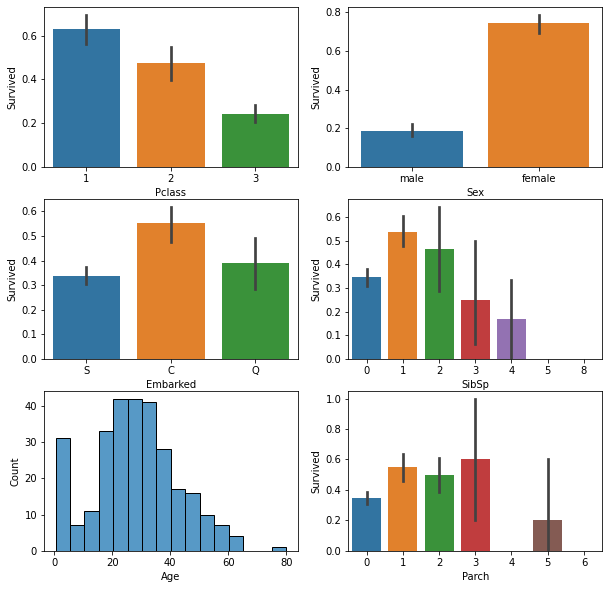

In [5]:
f, ax = plt.subplots(3,2, figsize=[10,10])
sns.barplot(x='Pclass', y='Survived', data=train, ax=ax[0,0])
sns.barplot(x='Sex', y='Survived', data=train, ax=ax[0,1])
sns.barplot(x='Embarked', y='Survived', data=train, ax=ax[1,0])
sns.barplot(x='SibSp', y='Survived', data=train, ax=ax[1,1])
sns.barplot(x='Parch', y='Survived',data=train, ax=ax[2,1])
sns.histplot(x='Age', data=train[train['Survived']==1], ax=ax[2,0])
plt.savefig('2.png')

**Observations**

1. Pclass == 1 has highest probability of surviving.
2. Females have higher chance of survival.
3. Passengers from C station have higher chance of survival.
4. People with Sibsp 1 and 2 have better chance of survival.
5. People between age 20 and 40 and infants have higher count in survived passengers.
6. Parch column with 1,2,3 has similar chance of survival.

Since there is not much conclusive evidence from plot 4 and 6, we will engineer features from Parch and Sibsp column into Family and Alone columns.(https://www.kaggle.com/l3r4nd/titanic-prediction-with-svm)

Embarked has 2 missing values, we fill them depending on their Survival class. 

In [6]:
nan_row = train[train['Embarked'].isnull()]
for i in nan_row.index:
    if train['Survived'][i] == 1:
        train['Embarked'][i] = 'C'
    else:
        train['Embarked'][i] = 'S'
    

<ipython-input-6-751cea3f012a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Embarked'][i] = 'C'


In [7]:
def get_age_group(data):
    age_group = []
    for i in range(len(data)):
        if data['age_median'][i] <= 20:
            age_group.append(1)
        elif data['age_median'][i] > 20 and data['age_median'][i] <= 40 :
            age_group.append(2)
        elif data['age_median'][i] > 40 and data['age_median'][i] <= 60 :
            age_group.append(3)
        else:
            age_group.append(4)
    return age_group

In [8]:
#https://www.kaggle.com/l3r4nd/titanic-prediction-with-svm
def get_fare_group(data):
    payment = data.groupby('Pclass')['Fare'].mean()
    data.loc[(data['Fare'] < payment[3]),'FareGroup'] = 1
    data.loc[(data['Fare'] > payment[3]) & (data['Fare'] <  payment[2]),'FareGroup'] = 2
    data.loc[(data['Fare'] > payment[2]) & (data['Fare'] <  payment[1]), 'FareGroup'] = 3
    data.loc[(data['Fare'] > payment[1]),'FareGroup'] = 4
    data['FareGroup'] = data['FareGroup'].astype(int)
    

In [9]:
test['Fare'].fillna(test['Fare'].median(), inplace=True)
get_fare_group(train)
get_fare_group(test)

The above function divides the age columns into different age groups. We have divided age groups depending on the number of passengers that survived the disaster.

In [10]:
train['age_median'] = train['Age']
#train['age_mean'] = train['Age']
test['age_median'] = test['Age']
#test['age_mean'] = test['Age']

In [11]:
train['age_median'].fillna(train['age_median'].median(), inplace=True)
#train['age_mean'].fillna(train['age_mean'].mean(), inplace=True)
test['age_median'].fillna(test['age_median'].median(), inplace=True)
#test['age_mean'].fillna(test['age_mean'].mean(), inplace=True)

In [12]:
train['age_group'] = get_age_group(train)
test['age_group'] = get_age_group(test)

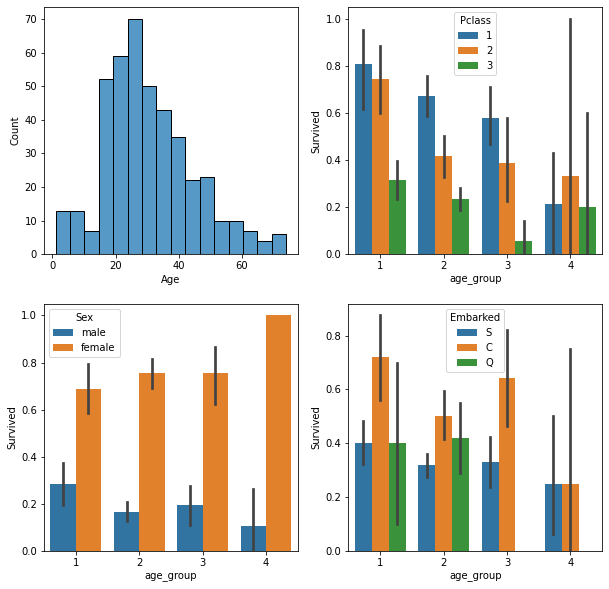

In [13]:
f, ax = plt.subplots(2,2, figsize=(10,10))
sns.histplot(x='Age', data=train[train['Survived']==0], ax=ax[0,0])
sns.barplot(x='age_group', y='Survived', data=train, hue='Pclass', ax=ax[0,1])
sns.barplot(x='age_group', y='Survived', data=train, hue='Sex', ax=ax[1,0])
sns.barplot(x='age_group', y='Survived', data=train, hue='Embarked', ax=ax[1,1])
plt.savefig('1.png')

**Observations**

7. From 5 we know that between 20 and 40 years the survival rate is high. Similarly Death rate is also high between 20 and 40 years. This is because number of passengers on board the ship are mostly between 20 and 40 years.
8. After dividing into age groups and plotting the survival rate barplot for age_group with Pclass, all groups have higher survival rate for Pclass 1.
9. All age_group have higher survival rate in case of females.
10. Age group 4 have higher survival rate for passengers embarked from 'Q' station while others from 'C' station. This also might be due to NA values.

*Taking above observations into account we will form our decision rules to fill NA values for Age column*

For example, 

if Survived == 1:

    if Pclass == 1:
    
        age_group = 2
        
    if Pclass == 2:
    
        age_group = 1
        
    if Pclass == 3:
    
        age_group = 5

- Filling age with median and mode in different columns for NA values

In [14]:
#https://www.kaggle.com/l3r4nd/titanic-prediction-with-svm
def get_family(data):
    data['Family'] = data['SibSp'] + data['Parch'] + 1
    data['Alone']  = data['Family'].apply(lambda x: 1 if x == 1 else 0)
    data.drop(['SibSp','Parch'],axis = 1, inplace = True)


In [15]:
get_family(train)   
get_family(test)

In [16]:
def get_family_group(data):
    data.loc[data['Family'] > 2, 'FamilyGroup'] = 3
    data.loc[data['Family'] == 1, 'FamilyGroup'] = 1
    data.loc[data['Family'] == 2, 'FamilyGroup'] = 2
    

In [17]:
get_family_group(train)
get_family_group(test)

- The Sibsp and Parch columns did not provide relevant information to predict. Therefore we have followed the notebook link above to create a Family group column where if there are more than 2 members the survival rate is less compared to 1 and 2 members.

In [18]:
train.drop(['PassengerId', 'Ticket', 'Family', 'Alone', 'Age', 'Fare'], axis=1, inplace=True)
test.drop(['Ticket', 'Age', 'Fare', 'Family', 'Alone'], axis=1, inplace=True)

In [19]:
def get_title_group(data):
    data['Title'] = data['Name'].apply(lambda x: str(x).split(',')[1].split('.')[0])
    data['Titlegroup'] = 0
    data['Titlegroup'] = data['Title'].replace(['Mme', 'Ms', 'Lady', 'Sir', 'Mlle', 'the Countess',], 0,  #High
                                            regex=True).replace(['Mrs','Miss','Master',],1,               #Medium
                                            regex = True).replace(['Dr','Major','Col','Mr'],2,              #Low
                                            regex = True).replace(['Don','Rev','Capt','Jonkheer','Dona'],4, #Least
                                            regex = True)
    data.drop(['Title', 'Name'], axis=1, inplace=True)

In [20]:
get_title_group(train)
get_title_group(test)

In [21]:
def one_hot_encoding(col):
    for i in range(len(col)):
        if col[i] == 'S':
            col1.append(1)
            col2.append(0)
            col3.append(0)
        elif col[i] == 'C':
            col1.append(0)
            col2.append(1)
            col3.append(0)
        else:
            col1.append(0)
            col2.append(0)
            col3.append(1)
        
    return col1, col2, col3

In [22]:
col1, col2, col3 = [], [], []
col1, col2, col3 = one_hot_encoding(train['Embarked'])
train['Embarked_S'] = col1
train['Embarked_C'] = col2
train['Embarked_Q'] = col3

In [23]:
col1, col2, col3 = [], [], []
col1, col2, col3 = one_hot_encoding(test['Embarked'])
test['Embarked_S'] = col1
test['Embarked_C'] = col2
test['Embarked_Q'] = col3

In [24]:
train['Sex'].replace('male', 0, inplace=True)
train['Sex'].replace('female', 1, inplace=True)
test['Sex'].replace('male', 0, inplace=True)
test['Sex'].replace('female', 1, inplace=True)

In [25]:
train.drop(['Embarked'], axis=1, inplace=True)
test.drop(['Embarked'], axis=1, inplace=True)

In [26]:
train.head()

,Survived,Pclass,Sex,Cabin,FareGroup,age_median,age_group,FamilyGroup,Titlegroup,Embarked_S,Embarked_C,Embarked_Q
0,0,3,0,NaN,1,22.0,2,2.0,2,1,0,0
1,1,1,1,C85,3,38.0,2,2.0,1,0,1,0
2,1,3,1,NaN,1,26.0,2,1.0,1,1,0,0
3,1,1,1,C123,3,35.0,2,2.0,1,1,0,0
4,0,3,0,NaN,1,35.0,2,1.0,2,1,0,0


In [27]:
train['Cabin'] = train['Cabin'].fillna('X')

In [28]:
train['Cabin'] = train['Cabin'].apply(lambda x: str(x)[0])

In [29]:
train.Cabin.unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

- We fill NA values of cabin with 'X' and then use the first character in Cabin column as feature. We can see the number of unique Cabin values are ['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']

<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

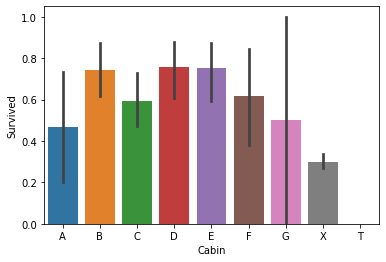

In [30]:
sns.barplot(x= 'Cabin', y = 'Survived', data = train ,order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'X', 'T'])

In [31]:
def cabin_group(data):
    data.loc[data['Cabin'] == 'B', 'cabinGroup'] = 1
    data.loc[data['Cabin'] == 'D', 'cabinGroup'] = 1
    data.loc[data['Cabin'] == 'E', 'cabinGroup'] = 1
    data.loc[data['Cabin'] == 'F', 'cabinGroup'] = 2
    data.loc[data['Cabin'] == 'C', 'cabinGroup'] = 2
    data.loc[data['Cabin'] == 'T', 'cabinGroup'] = 3
    data.loc[data['Cabin'] == 'G', 'cabinGroup'] = 3
    data.loc[data['Cabin'] == 'A', 'cabinGroup'] = 3
    data.loc[data['Cabin'] == 'X', 'cabinGroup'] = 4
    

In [32]:
cabin_group(train)

In [33]:
test['Cabin'] = test['Cabin'].fillna('X')
test['Cabin'] = test['Cabin'].apply(lambda x: str(x)[0])
cabin_group(test)

In [34]:
train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)
train.drop(['age_median'], axis=1, inplace=True)
test.drop(['age_median'], axis=1, inplace=True)

In [35]:
train_y = train.pop('Survived')

In [36]:
from sklearn import preprocessing

In [37]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [38]:
X = train
Y = train_y
X_test = test

**Linear SVM**

In [39]:
from sklearn import svm
clf_l = svm.SVC()
clf_l.fit(X,Y)

SVC()

In [70]:
score = cross_val_score(clf_l, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()
score

0.8192759051186018

In [40]:
pred = clf_l.predict(X_test)
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})
prediction.to_csv('Results_linearsvm.csv', index=False)

**Non Linear SVM**

In [41]:
clf = svm.NuSVC(kernel='linear')
clf.fit(X,Y)

NuSVC(kernel='linear')

In [42]:
score = cross_val_score(clf, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()
score

0.7935081148564295

In [43]:
pred = clf.predict(X_test)
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})
prediction.to_csv('Results_svm.csv', index=False)

In [44]:
clf = svm.NuSVC(kernel='rbf')
clf.fit(X,Y)
score = cross_val_score(clf, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()
score

0.8080649188514357

In [45]:
pred = clf.predict(X_test)
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})
prediction.to_csv('Results_svm_rbf.csv', index=False)

**XGBoost**

In [46]:
from xgboost import XGBClassifier

In [47]:
clf_xg = XGBClassifier(encoder=False)

In [48]:
clf_xg.fit(X,Y)

[18:47:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:47:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ajayc\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, encoder=False, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
score = cross_val_score(clf_xg, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()

In [50]:
pred = clf_xg.predict(X_test)

In [51]:
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})

In [52]:
prediction.to_csv('Results_xg.csv', index=False)

In [53]:
score

0.8249313358302123

**Decision Tree**

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [55]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X,Y)

DecisionTreeClassifier()

In [56]:
score = cross_val_score(clf_dt, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()

In [57]:
score

0.8069787765293382

In [58]:
pred = clf_dt.predict(X_test)
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})
prediction.to_csv('Results_dt.csv', index=False)

**Random Forest**

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X,Y)

RandomForestClassifier()

In [61]:
score = cross_val_score(clf_rf, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()

In [62]:
score

0.8249188514357053

In [63]:
pred = clf_rf.predict(X_test)
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})
prediction.to_csv('Results_rf.csv', index=False)

**Neural Network**

In [64]:
from sklearn.neural_network import MLPClassifier

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [66]:
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [67]:
clf_nn =  MLPClassifier(
            solver='lbfgs', alpha=1e-2, random_state=1, max_iter=10000,
            early_stopping=True, hidden_layer_sizes=[10, 10],
        )
clf_nn.fit(X,Y)

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=[10, 10],
              max_iter=10000, random_state=1, solver='lbfgs')

In [68]:
score = cross_val_score(clf_nn, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()
score

0.8002372034956304

In [69]:
pred = clf_dt.predict(X_test)
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})
prediction.to_csv('Results_nn.csv', index=False)